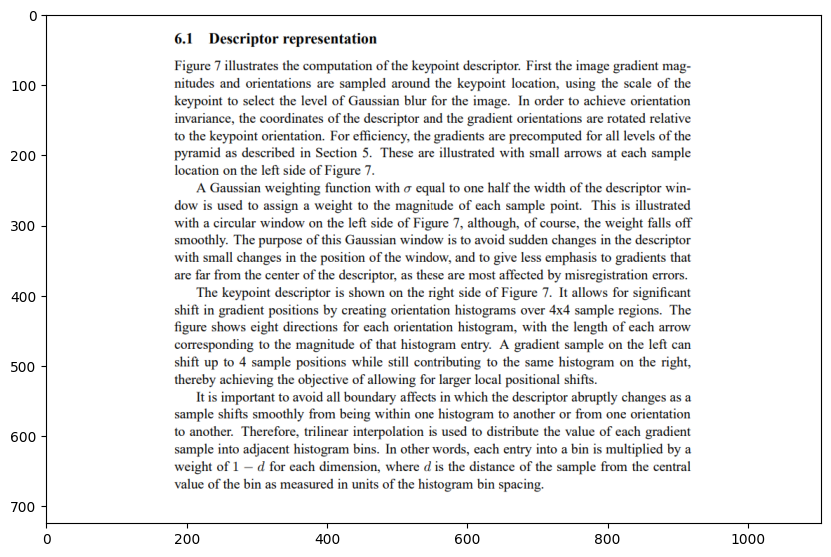

In [28]:
import cv2
import matplotlib.pyplot as plt

imgs = [cv2.cvtColor(cv2.imread(f"/kaggle/input/cv2-q3/3.{i}.png"), cv2.COLOR_BGR2RGB) for i in range(9)]
plt.figure(figsize=(10,10))
plt.imshow(imgs[0])

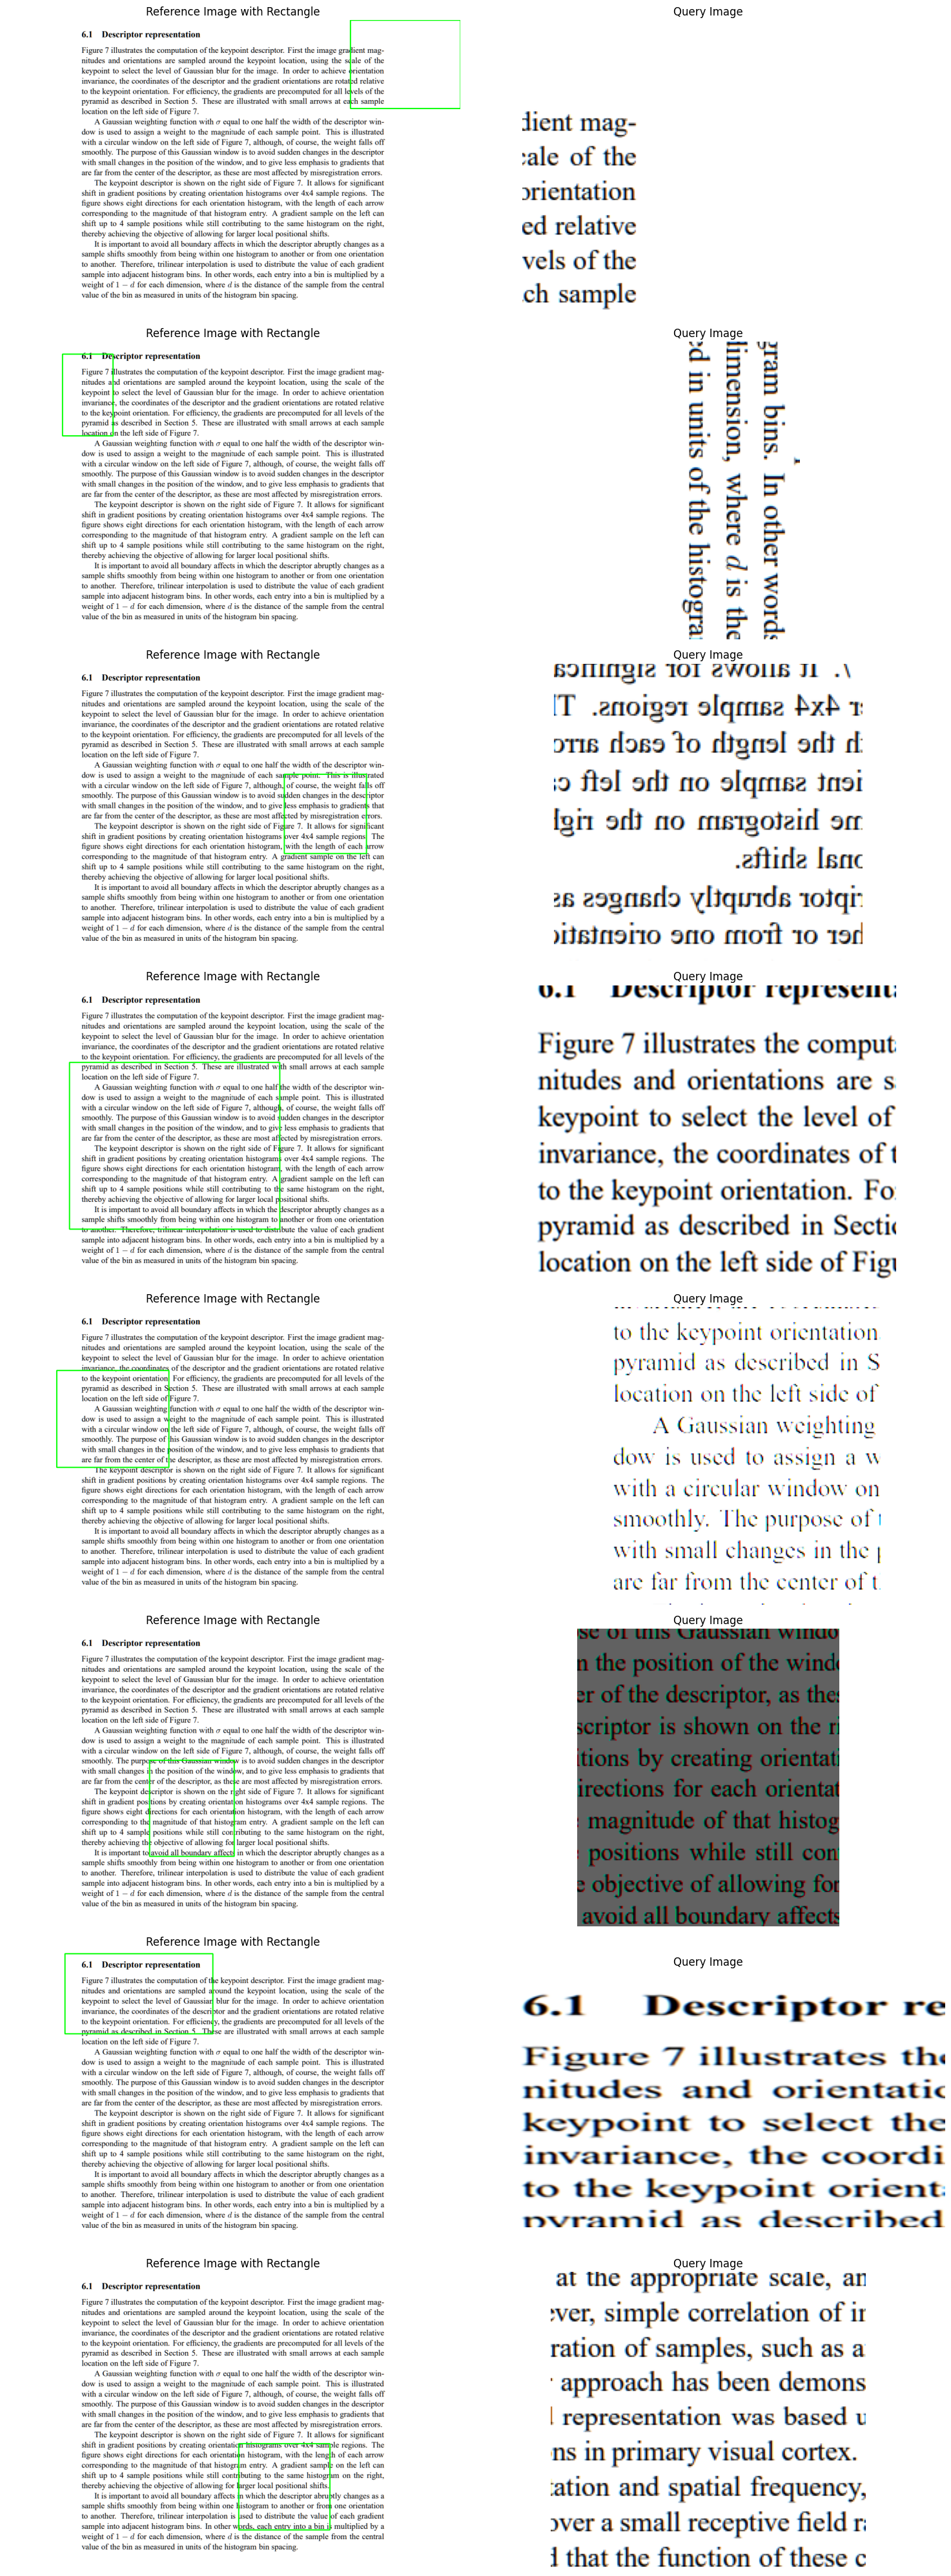

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure

gray_imgs = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in imgs]

# Extract HOG features
def get_hog_features(image):
    features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=True)
                              #image: This is the input image for which the HOG descriptor needs to be computed.
#orientations: the number of orientation bins used in the HOG descriptor.  (180 degrees / 9 = 20 degrees).
#pixels_per_cell: the size of each cell in the HOG descriptor, measured in pixels.
#cells_per_block: the number of cells in each block of the HOG descriptor. The default value is (2, 2), which means that each block consists of a 2x2 grid of cells.
#visualize: a boolean value that determines whether the function should return the HOG descriptor and an image visualization of the HOG features. 
# features:  HOG descriptor, which is a 1D numpy array containing the computed features.
# hog_image:  It is a 2D numpy array representing an image visualization of the computed HOG features.

    return features, hog_image

# Template matching function
def template_matching(reference_image, query_image):
    result = cv2.matchTemplate(reference_image, query_image, cv2.TM_CCOEFF_NORMED) #cv2.TM_CCOEFF_NORMED: This is one of the methods used for comparison.
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    top_left = max_loc
    h, w = query_image.shape
    bottom_right = (top_left[0] + w, top_left[1] + h)
    return top_left, bottom_right

# Visualization function
def visualize_matches(reference_image, query_images, match_locations):
    fig, axs = plt.subplots(len(query_images), 2, figsize=(15, len(query_images) * 5))
    
    for i, (query_image, (top_left, bottom_right)) in enumerate(zip(query_images, match_locations)):
        # Draw rectangle on the reference image
        reference_with_rectangle = reference_image.copy()
        cv2.rectangle(reference_with_rectangle, top_left, bottom_right, (0, 255, 0), 2)

        # Plot reference image with rectangle
        axs[i, 0].imshow(cv2.cvtColor(reference_with_rectangle, cv2.COLOR_BGR2RGB))
        axs[i, 0].set_title('Reference Image with Rectangle')
        axs[i, 0].axis('off')

        # Plot query image
        axs[i, 1].imshow(cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB))
        axs[i, 1].set_title('Query Image')
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Perform template matching for each query image against the reference image
reference_image = imgs[0]
gray_reference = gray_imgs[0]
match_locations = [template_matching(gray_reference, img) for img in gray_imgs[1:]]

# Visualize the matches
visualize_matches(reference_image, imgs[1:], match_locations)


**sift**

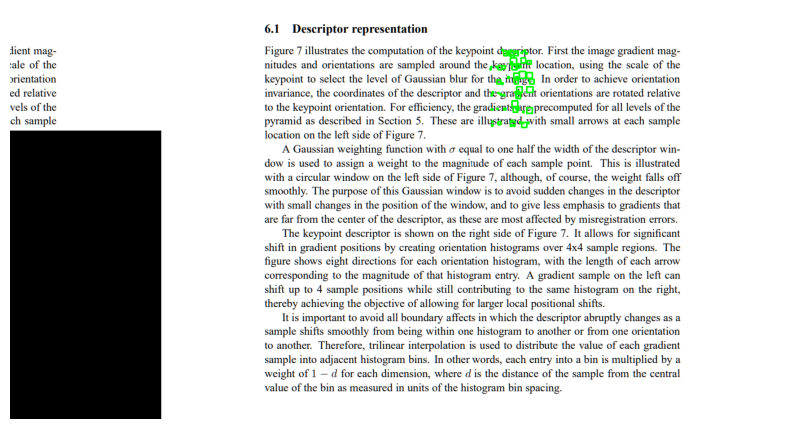

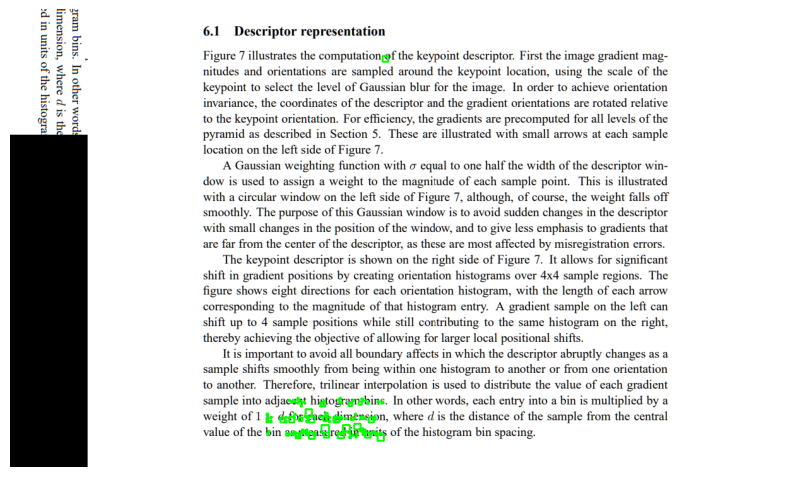

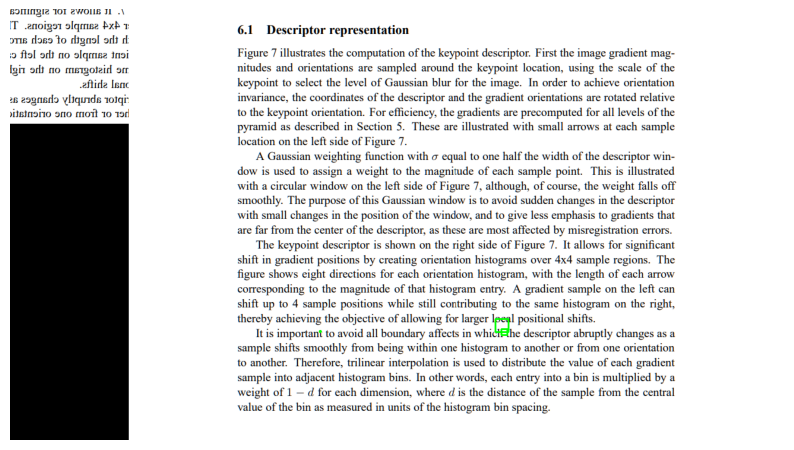

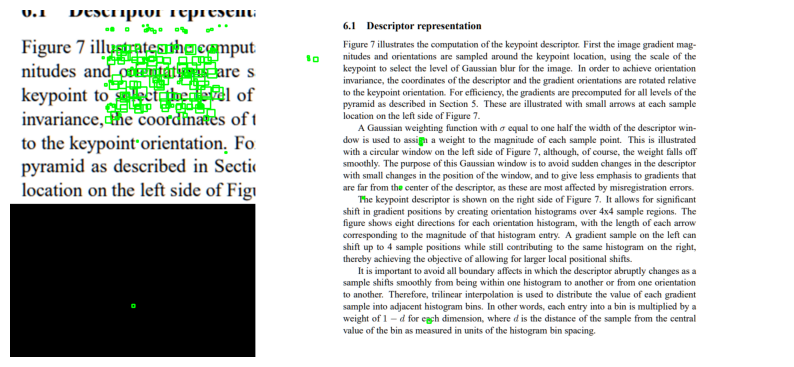

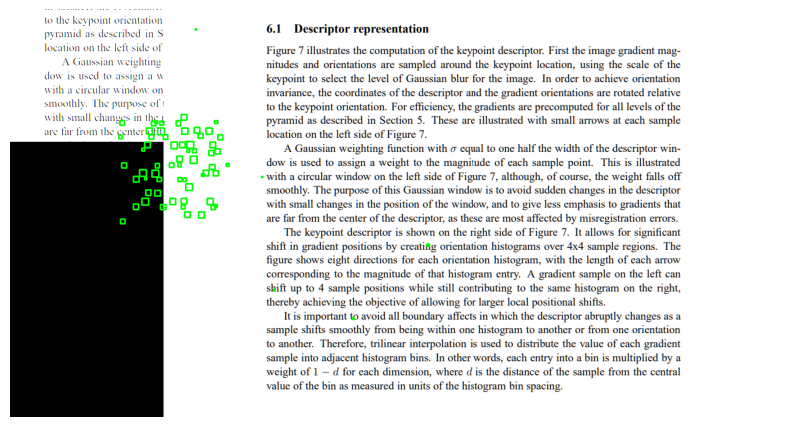

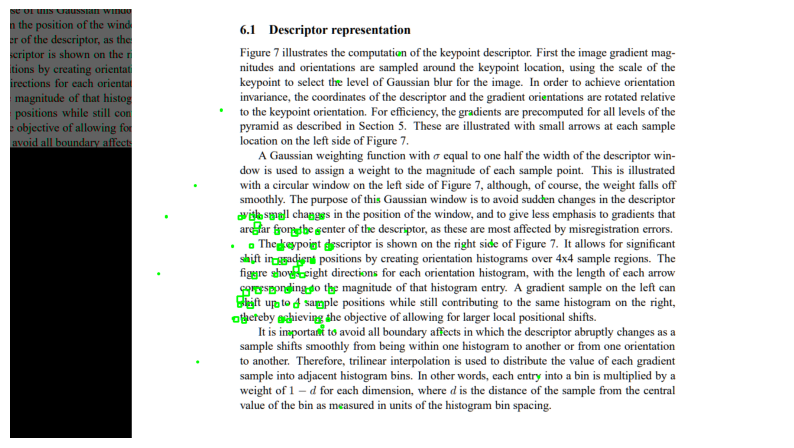

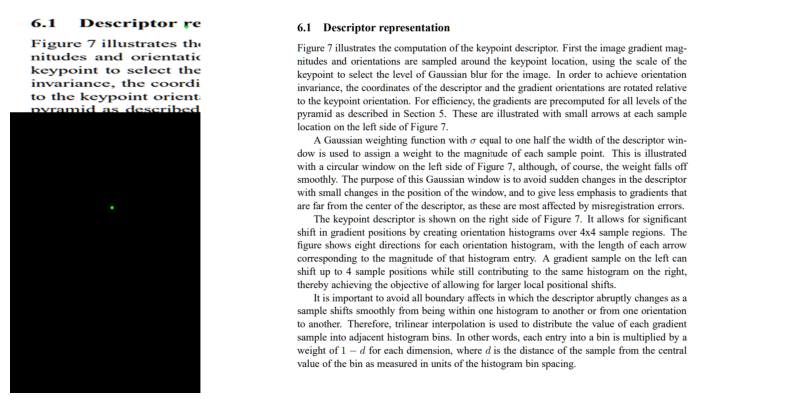

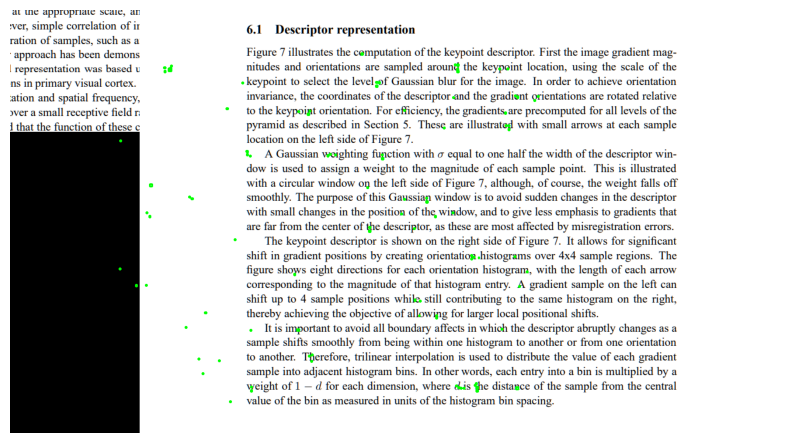

In [42]:
# Create a SIFT feature detector
sift = cv2.SIFT_create()

# Create a Brute-Force matcher
bf = cv2.BFMatcher(cv2.NORM_L2) # creates a Brute-Force matcher object, which will be used to match the SIFT features between the reference and query images.
#The cv2.NORM_L2 parameter specifies the distance metric to use, in this case, the Euclidean distance.

# Extract SIFT features from the reference image
kp_ref, des_ref = sift.detectAndCompute(imgs[0], None) #extracts the SIFT keypoints and descriptors from the reference image

# Loop through the query images
for i in range(1, 9):
    # Extract SIFT features from the query image
    kp_query, des_query = sift.detectAndCompute(imgs[i], None)

    # Match features between the query and reference images
    matches = bf.knnMatch(des_query, des_ref, k=2)

    # Apply ratio test to filter out weak matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # Draw the query and reference images side by side
    img_query = imgs[i]
    img_ref = imgs[0]
    h, w, _ = img_query.shape
    img_comb = np.zeros((max(img_query.shape[0], img_ref.shape[0]), w + img_ref.shape[1], 3), dtype=np.uint8)
    img_comb[:img_query.shape[0], :w] = img_query
    img_comb[:img_ref.shape[0], w:] = img_ref

    # Draw a rectangle around the query image in the reference image
    x, y, w, h = 0, 0, 0, 0
    for m in good_matches:
         # Get the keypoint from the reference image
        x, y = kp_ref[m.trainIdx].pt
        w, h = kp_query[m.queryIdx].size, kp_query[m.queryIdx].size
        cv2.rectangle(img_comb, (int(x + w), int(y)), (int(x + w + w), int(y + h)), (0, 255, 0), 2)

    # Display the combined image
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(img_comb, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()